In [55]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Обработка датасета

In [56]:
df = pd.read_csv('realtor-data.csv')
df

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0
...,...,...,...,...,...,...,...,...,...,...
904961,for_sale,2.0,2.0,NaN,New York City,New York,10463.0,NaN,2021-08-13,359000.0
904962,for_sale,2.0,2.0,NaN,Bronx,New York,10463.0,1200.0,NaN,299000.0
904963,for_sale,NaN,1.0,NaN,Bronx,New York,10463.0,NaN,NaN,120000.0
904964,for_sale,3.0,2.0,NaN,Bronx,New York,10463.0,NaN,NaN,449000.0


### Дистилляция датасета

In [57]:
df = df.drop(['zip_code', 'prev_sold_date'], axis = 1)

numeric_features = df.select_dtypes([np.number]).columns
cat_features = df.select_dtypes([object]).columns

df

,status,bed,bath,acre_lot,city,state,house_size,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,920.0,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,1527.0,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,748.0,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,1800.0,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,NaN,65000.0
...,...,...,...,...,...,...,...,...
904961,for_sale,2.0,2.0,NaN,New York City,New York,NaN,359000.0
904962,for_sale,2.0,2.0,NaN,Bronx,New York,1200.0,299000.0
904963,for_sale,NaN,1.0,NaN,Bronx,New York,NaN,120000.0
904964,for_sale,3.0,2.0,NaN,Bronx,New York,NaN,449000.0


### Обработка пропущенных значений

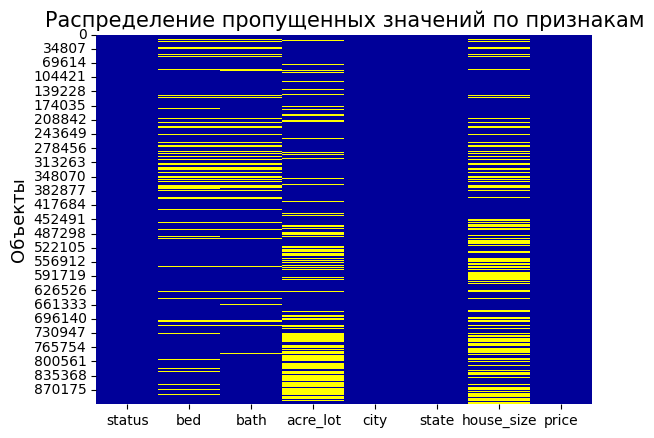

In [58]:
s = sns.heatmap(df.isnull(), cmap = sns.color_palette(['#000099', '#ffff00']), cbar = False)
s.set_ylabel('Объекты', fontsize = 13)
s.set_title('Распределение пропущенных значений по признакам', fontsize = 15)

plt.show()

In [59]:
print(f'Количество объектов с пропущенными значениями: {df.isnull().any(axis = 1).sum()}') 

Количество объектов с пропущенными значениями: 491819


In [60]:
mis = {}

for feature in df.columns:
    mis[feature] = np.mean(df[feature].isnull()) * 100

for feature, val in sorted(mis.items(), key = lambda item: item[1], reverse = True):
    print(f'{feature} - {np.mean(df[feature].isnull()) * 100:.2f}%')

house_size - 32.36%
acre_lot - 29.46%
bed - 14.35%
bath - 12.58%
city - 0.01%
price - 0.01%
status - 0.00%
state - 0.00%


In [61]:
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())
df[cat_features]= df[cat_features].apply(lambda col: col.fillna(col.value_counts().index[0]))

In [62]:
print(f'Количество объектов с пропущенными значениями: {df.isnull().any(axis = 1).sum()}') 

Количество объектов с пропущенными значениями: 0


### Обработка выбросов

In [63]:
def show_boxplots(df, title = None):

    rows_cnt = int(np.ceil(len(df.columns) / 2))

    fig = plt.figure(layout = 'constrained', figsize = (10, 10))
    gs = GridSpec(rows_cnt, 2, figure = fig)

    for i, feature in enumerate(df.columns):
        ax = fig.add_subplot(gs[i // 2, i % 2])
        df.boxplot(column = feature, ax = ax)

    plt.suptitle(title, fontsize = 15)
    plt.show()

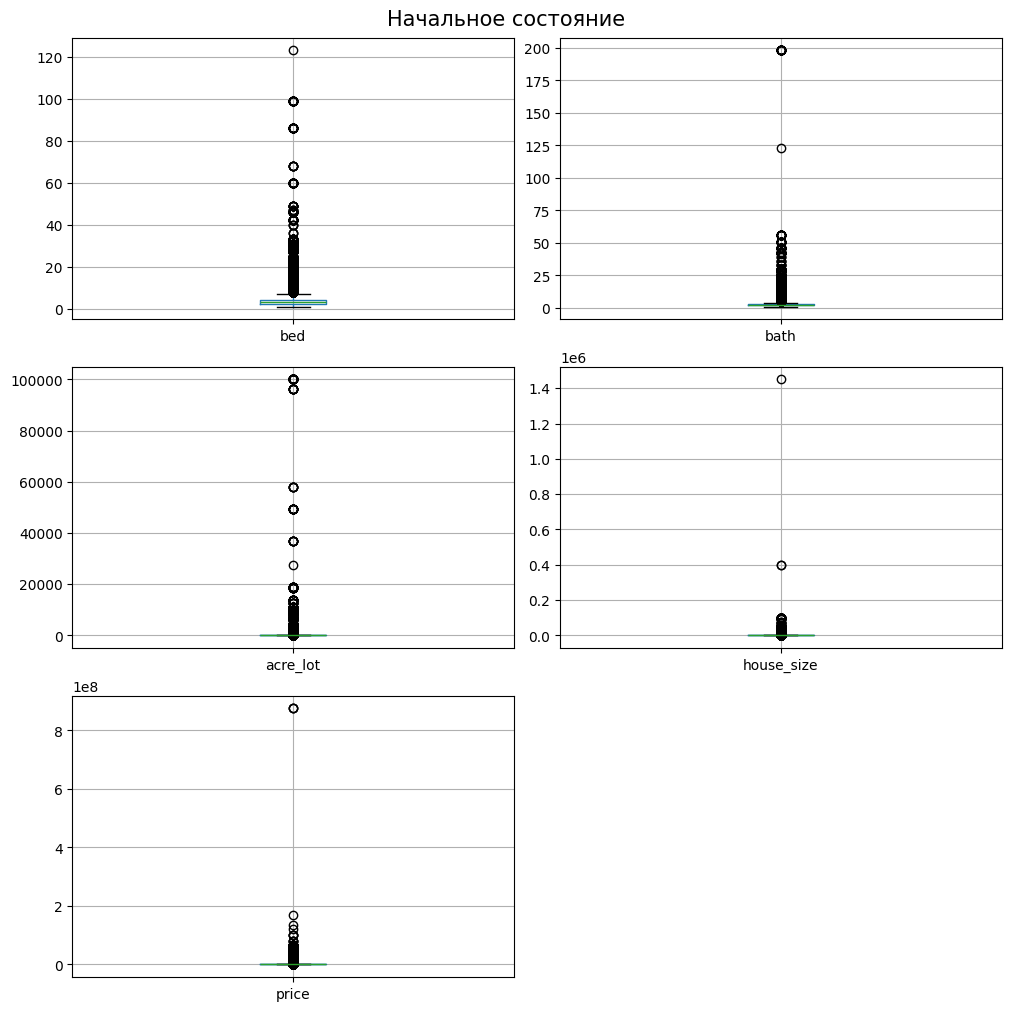

In [64]:
show_boxplots(df[numeric_features], title = 'Начальное состояние')

In [65]:
df.describe()

,bed,bath,acre_lot,house_size,price
count,904966.000000,904966.000000,904966.000000,9.049660e+05,9.049660e+05
mean,3.284529,2.423298,12.300318,1.980358e+03,8.774066e+05
std,1.914962,1.813124,815.290480,2.515951e+03,2.457604e+06
min,1.000000,1.000000,0.000000,1.000000e+02,0.000000e+00
25%,2.000000,2.000000,0.170000,1.360000e+03,2.688880e+05
50%,3.000000,2.000000,0.290000,1.650000e+03,4.750000e+05
75%,4.000000,3.000000,0.600000,2.016000e+03,8.300000e+05
max,123.000000,198.000000,100000.000000,1.450112e+06,8.750000e+08


In [66]:
# Анализ с помощью межквантильного размаха
for feature in numeric_features:

    Q1 = df[feature].quantile(q = .25)
    Q3 = df[feature].quantile(q = .75)
    IQR = Q3 - Q1

    df = df[(df[feature] >= Q1 - 1.5 * IQR) & (df[feature] <= Q3 + 1.5 + IQR)] 

df = df.reset_index(drop = True)
df

,status,bed,bath,acre_lot,city,state,house_size,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,920.0,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,1527.0,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,748.0,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,1800.0,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,1650.0,65000.0
...,...,...,...,...,...,...,...,...
593778,for_sale,2.0,2.0,0.29,New York City,New York,1650.0,359000.0
593779,for_sale,2.0,2.0,0.29,Bronx,New York,1200.0,299000.0
593780,for_sale,3.0,1.0,0.29,Bronx,New York,1650.0,120000.0
593781,for_sale,3.0,2.0,0.29,Bronx,New York,1650.0,449000.0


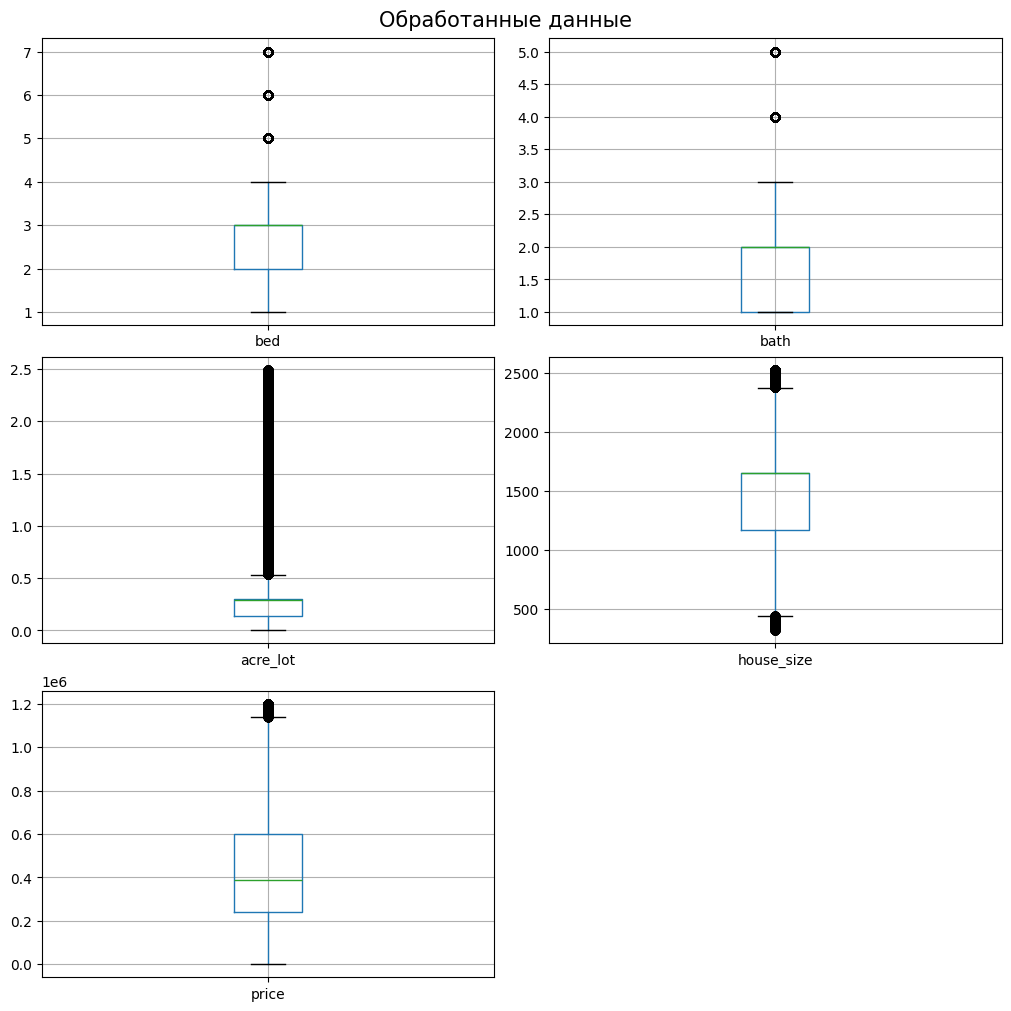

In [67]:
show_boxplots(df[numeric_features], title = 'Обработанные данные')

In [68]:
df.describe()

,bed,bath,acre_lot,house_size,price
count,593783.000000,593783.000000,593783.000000,593783.000000,5.937830e+05
mean,2.836046,1.957565,0.381732,1482.383037,4.348337e+05
std,1.127163,0.821261,0.433599,441.322690,2.627919e+05
min,1.000000,1.000000,0.000000,319.000000,0.000000e+00
25%,2.000000,1.000000,0.140000,1166.000000,2.390000e+05
50%,3.000000,2.000000,0.290000,1650.000000,3.890000e+05
75%,3.000000,2.000000,0.300000,1650.000000,5.990000e+05
max,7.000000,5.000000,2.490000,2525.000000,1.199686e+06


## Зависимости признаков

<Axes: >

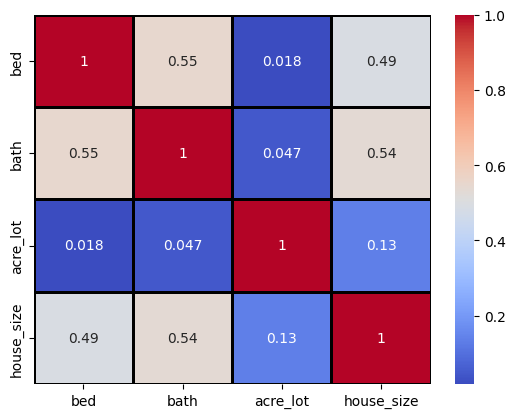

In [69]:
sns.heatmap(df[numeric_features].drop(['price'], axis = 1).corr(), 
            cmap = 'coolwarm', 
            linewidths = 2, 
            linecolor = 'black', 
            annot = True)

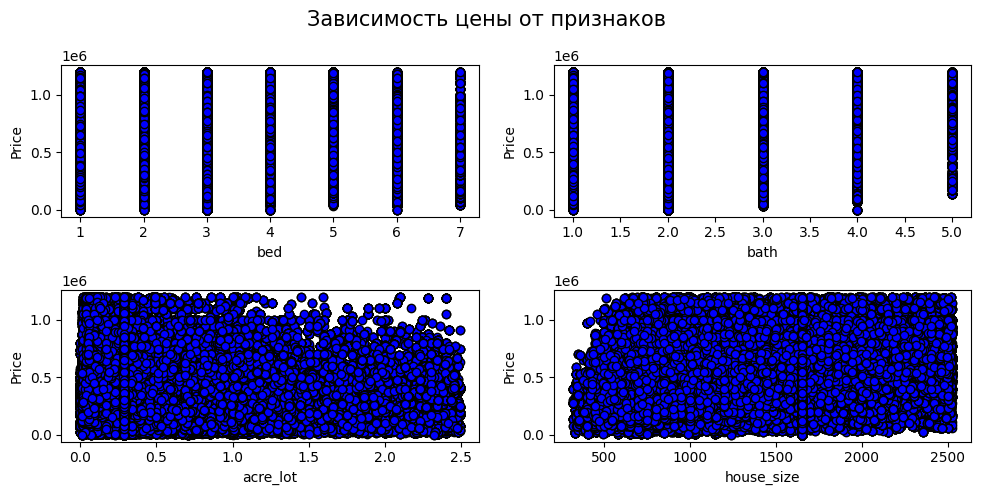

In [70]:
fig, axs = plt.subplots(2, 2, figsize = (10, 5))

for feature, ax in zip(df[numeric_features].drop(['price'], axis = 1).columns, axs.flatten()):
  
    ax.scatter(df[feature], df['price'], color = 'b', edgecolors = 'black')

    ax.set_xlabel(feature)
    ax.set_ylabel('Price')

plt.suptitle('Зависимость цены от признаков', fontsize = 15)
plt.tight_layout()
plt.show()

# Задание 1, 2

In [71]:
def plot_regression(regressor, df, title = ''):
    _, axs = plt.subplots(2, 2, figsize = (10, 5))

    for feature, ax in zip(df.drop(['price'], axis = 1).columns, axs.flatten()):

        df_sort = df.sort_values(by = feature)
        X = np.reshape(df_sort.drop(['price'], axis = 1)[feature], (-1, 1))   
        y_true = df_sort['price']
        
        reg = regressor().fit(X, y_true)
        y_pred = reg.predict(X)
        
        ax.scatter(df[feature], df['price'], color = 'b', edgecolors = 'black')
        ax.plot(X, y_pred, color = 'orange', linewidth = 3)
        
        ax.set_xlabel(feature)
        ax.set_ylabel('Price')

    plt.suptitle(reg.__class__.__name__ + '\n' + title, fontsize = 15)
    plt.tight_layout()
    plt.show()

In [72]:
def get_MSE(regressors, X, y_true):
    
    for regressor in regressors:
        y_pred = regressor.fit(X, y_true).predict(X)
        print(f'MSE({regressor.__class__.__name__}) = {mean_squared_error(y_true, y_pred):.2e}')

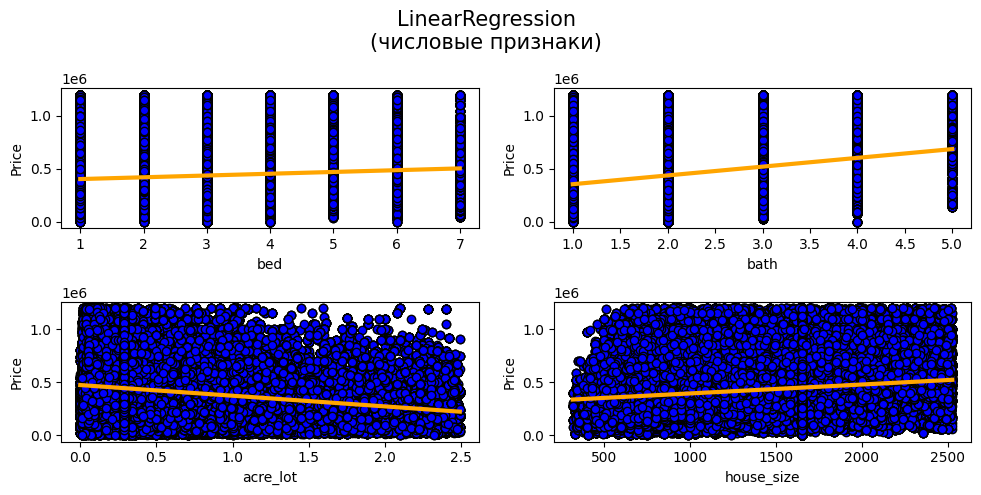

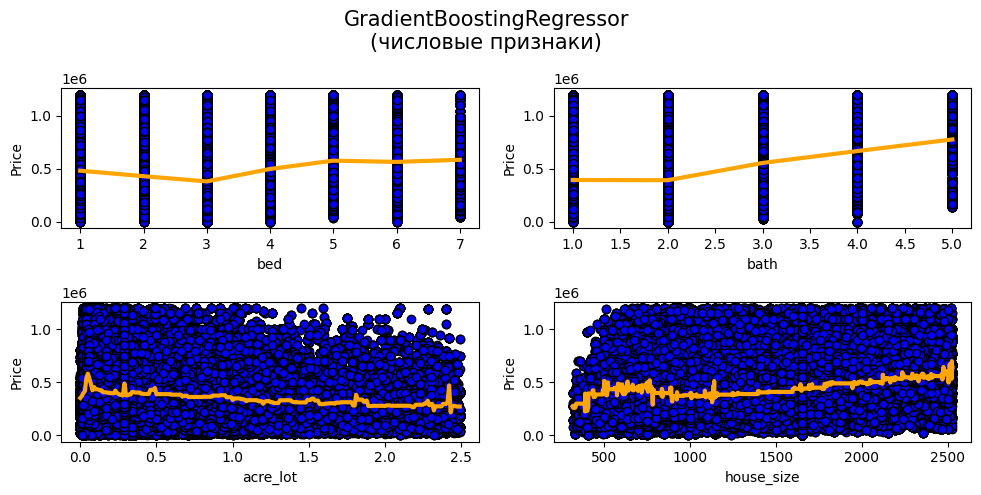

In [73]:
plot_regression(LinearRegression, df[numeric_features], title = '(числовые признаки)')
plot_regression(GradientBoostingRegressor, df[numeric_features], title = '(числовые признаки)')

In [74]:
X = df[numeric_features].drop(['price'], axis = 1)
y_true = df['price']

get_MSE([LinearRegression(), GradientBoostingRegressor()], X, y_true)

MSE(LinearRegression) = 6.15e+10
MSE(GradientBoostingRegressor) = 5.21e+10


# Задание 3

### OneHotEncoding

In [75]:
df_one_hot = pd.get_dummies(df[cat_features], dtype = int)
df_one_hot

,status_for_sale,status_ready_to_build,city_Abbot,city_Aberdeen,city_Abington,city_Absecon,city_Accord,city_Acton,city_Acushnet,city_Adams,...,state_Pennsylvania,state_Puerto Rico,state_Rhode Island,state_South Carolina,state_Tennessee,state_Vermont,state_Virgin Islands,state_Virginia,state_West Virginia,state_Wyoming
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593778,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
593779,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
593780,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
593781,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
get_MSE([LinearRegression(), GradientBoostingRegressor()], df_one_hot, df['price'])

MSE(LinearRegression) = 3.46e+10
MSE(GradientBoostingRegressor) = 4.69e+10


### TargetEncoding

In [77]:
df_target_enc = TargetEncoder(target_type = 'continuous').fit_transform(df[cat_features], df['price'])
df_target_enc

array([[434617.96428575,  93491.04207986, 176013.60216306],
       [434570.62597024,  93491.06616226, 176610.61268219],
       [434617.96428575,  97900.46290332, 176013.60216306],
       ...,
       [434223.68371877, 450090.08733753, 619573.20561464],
       [434617.96428575, 448262.69447995, 619861.34632531],
       [434617.96428575, 687400.24355339, 619861.34632531]])

In [78]:
get_MSE([LinearRegression(), GradientBoostingRegressor()], df_target_enc, df['price'])

MSE(LinearRegression) = 3.56e+10
MSE(GradientBoostingRegressor) = 3.50e+10


# Задание 4

In [79]:
pca = PCA(2).fit_transform(df[numeric_features].drop(['price'], axis = 1))    

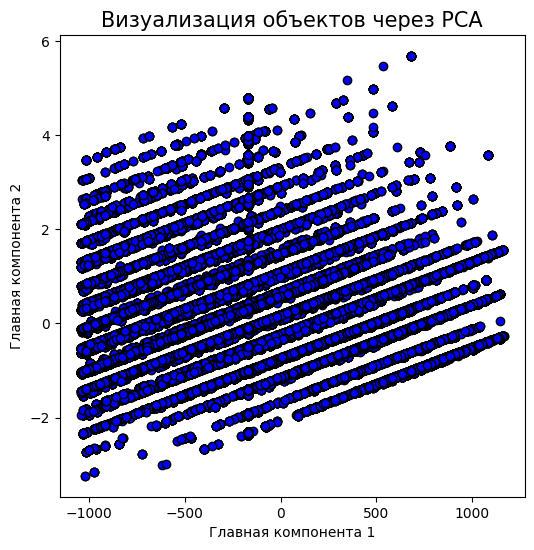

In [80]:
plt.figure(figsize = (6, 6))
plt.scatter(pca[:, 0], pca[:, 1], color = 'b', edgecolors = 'black')

plt.title('Визуализация объектов через PCA', fontsize = 15)

plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()